In [ ]:
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score
)

RANDOM_STATE = 42
CSV_PATH = "Trial_Data.csv"

In [ ]:
df = pd.read_csv(CSV_PATH)

# Expected columns (lowercase in trial):
# ['text','lang','polarization','gender/sexual','political','religious','racial/ethnic','other', ...]
print("Columns:", list(df.columns))
print("Total rows:", len(df))
display(df.head(3))

Columns: ['text', 'lang', 'polarization', 'gender/sexual', 'political', 'religious', 'racial/ethnic', 'other', 'vilification', 'extreme_language', 'stereotype', 'invalidation', 'lack_of_empathy', 'dehumanization', 'id']
Total rows: 338


,text,lang,polarization,gender/sexual,political,religious,racial/ethnic,other,vilification,extreme_language,stereotype,invalidation,lack_of_empathy,dehumanization,id
0,እንደምን አደራችሁ ቤዛ! የ እለቱን ቃል በ ፓስተር ፍቅሬ በላይ እነሆ! ...,amh,0,0,0,0,0,0,0,0,0,0,0,0,amh_4a249cbbca6389d5120fe9b556f5ebf2
1,@USER ተሌግራምን እንደ አማራጭ መጠቀም መልካም ይመስለኛል::,amh,0,0,0,0,0,0,0,0,0,0,0,0,amh_01b5780721c676222b91ec97a797a066
2,አንደኛው አመት የፕሪቶርያው ስምምነት ምክንያት በማድረግ ከህዝባዊ ወያነ ...,amh,0,0,0,0,0,0,0,0,0,0,0,0,amh_7aabf3f2c41cbd032e6dbf56eccca9d7


In [ ]:
df_tr = df[df['lang'].astype(str).str.lower().eq('tur')].copy()
df_tr['text'] = df_tr['text'].astype(str).str.strip()
df_tr = df_tr[df_tr['text'].str.len() > 0].copy()

print("\nTurkish rows:", len(df_tr))
print("Class distribution (TR):")
print(df_tr['polarization'].value_counts())

# Target & raw text
y = df_tr['polarization'].astype(int).values
X_text = df_tr['text'].tolist()


Turkish rows: 19
Class distribution (TR):
polarization
0    10
1     9
Name: count, dtype: int64



[EDA] Text length (words) – summary:
count    19.000000
mean     20.894737
std      10.065865
min       7.000000
25%      13.500000
50%      19.000000
75%      27.500000
max      38.000000
Name: text_len, dtype: float64


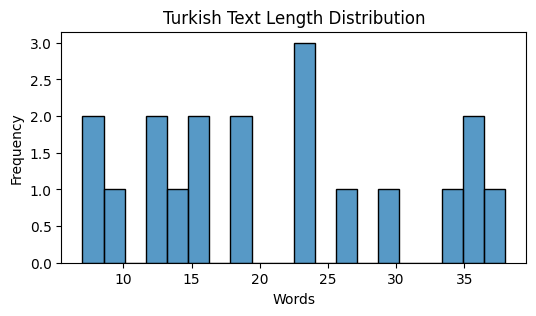


[EDA] Top unigrams in polarized=1:


,ngram,freq
0,bir,5
1,mı,3
2,daha,3
3,ama,3
4,vardır,2
5,nefret,2
6,isteyen,2
7,siz,2
8,mi,2
9,yanlış,2



[EDA] Top bigrams in polarized=1:


,ngram,freq
0,daha fazla,2
1,domuz eti,2
2,bir bildiği,2
3,ülke ve,1
4,öldürmeyi deniyor,1
5,çıkar elde,1
6,zulmune cocukicrasi,1
7,önce belediye,1
8,ın olmadığını,1
9,ülkeden birisi,1



[EDA] Top unigrams in polarized=0:


,ngram,freq
0,bir,5
1,devlet,4
2,için,4
3,bu,4
4,haklarını,4
5,savunmak,4
6,mi,3
7,ın,3
8,öğrenci,2
9,anayasa,2



[EDA] Top bigrams in polarized=0:


,ngram,freq
0,savunmak için,4
1,haklarını savunmak,4
2,ek 40,2
3,ın koordinasyonunda,1
4,ın stanbul,1
5,ülkemizin güçlü,1
6,ülke olarak,1
7,öğretmen geleceğe,1
8,öğrenci kadın,1
9,öğrenci haklarını,1


In [ ]:
df_tr['text_len'] = df_tr['text'].str.split().apply(len)
print("\n[EDA] Text length (words) – summary:")
print(df_tr['text_len'].describe())

plt.figure(figsize=(6,3))
sns.histplot(df_tr['text_len'], bins=20)
plt.title("Turkish Text Length Distribution")
plt.xlabel("Words"); plt.ylabel("Frequency")
plt.show()

def top_ngrams(corpus, ngram_range=(1,1), topk=15):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=1, max_features=200_000)
    Xmat = vec.fit_transform(corpus)
    freqs = np.asarray(Xmat.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:topk]
    return pd.DataFrame({"ngram": vocab[order], "freq": freqs[order]})

pos_texts = df_tr[df_tr['polarization'].eq(1)]['text'].tolist()
neg_texts = df_tr[df_tr['polarization'].eq(0)]['text'].tolist()

print("\n[EDA] Top unigrams in polarized=1:")
display(top_ngrams(pos_texts, (1,1), 15))
print("\n[EDA] Top bigrams in polarized=1:")
display(top_ngrams(pos_texts, (2,2), 15))

print("\n[EDA] Top unigrams in polarized=0:")
display(top_ngrams(neg_texts, (1,1), 15))
print("\n[EDA] Top bigrams in polarized=0:")
display(top_ngrams(neg_texts, (2,2), 15))


In [ ]:
from langdetect import detect_langs, DetectorFactory
DetectorFactory.seed = 42

# Light cleaner helps detection on short/social text
URL_RE     = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
MULTI_WS   = re.compile(r"\s+")

def clean_for_lang(s: str) -> str:
    s = str(s)
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = HASHTAG_RE.sub(" ", s)
    s = MULTI_WS.sub(" ", s).strip()
    return s

def detect_turkish_flag(text: str, p_thresh=0.70) -> bool:
    """Return True if langdetect says 'tr' with probability >= threshold."""
    try:
        langs = detect_langs(clean_for_lang(text))
        if not langs:
            return False
        top = max(langs, key=lambda x: x.prob)
        return (top.lang.startswith("tr")) and (top.prob >= p_thresh)
    except Exception:
        return False

df_tr['_is_detected_turkish'] = df_tr['text'].apply(detect_turkish_flag)
agreement = df_tr['_is_detected_turkish'].mean()
print(f"\n[Lang Agreement – Turkish subset only]: {agreement:.2f}")

mismatches = df_tr[df_tr['_is_detected_turkish'] == False][['id','text']]
print(f"Mismatched rows (detected NOT Turkish): {len(mismatches)}")
display(mismatches.head(10))


[Lang Agreement – Turkish subset only]: 1.00
Mismatched rows (detected NOT Turkish): 0


,id,text


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=100_000, min_df=1)),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced",
                               n_jobs=-1, random_state=RANDOM_STATE)),
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)[:, 1]

print("\n=== Hold-out (80/20) — TF-IDF + LR ===")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
try:
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))
except Exception:
    print("ROC-AUC: could not be computed (single-class test set).")


=== Hold-out (80/20) — TF-IDF + LR ===
              precision    recall  f1-score   support

           0     0.5000    0.5000    0.5000         2
           1     0.5000    0.5000    0.5000         2

    accuracy                         0.5000         4
   macro avg     0.5000    0.5000    0.5000         4
weighted avg     0.5000    0.5000    0.5000         4

Confusion matrix:
 [[1 1]
 [1 1]]
ROC-AUC: 0.5


In [ ]:
texts = np.array(X_text)
targets = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accs, f1_mi, f1_ma, aucs = [], [], [], []

for tr, te in skf.split(texts, targets):
    Xtr, Xte = texts[tr].tolist(), texts[te].tolist()
    ytr, yte = targets[tr], targets[te]
    model = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=100_000, min_df=1)),
        ("clf", LogisticRegression(max_iter=300, class_weight="balanced",
                                   n_jobs=-1, random_state=RANDOM_STATE)),
    ])
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)
    accs.append(accuracy_score(yte, yhat))
    f1_mi.append(f1_score(yte, yhat, average="micro", zero_division=0))
    f1_ma.append(f1_score(yte, yhat, average="macro", zero_division=0))
    try:
        aucs.append(roc_auc_score(yte, model.predict_proba(Xte)[:, 1]))
    except Exception:
        pass

def mean_std(x):
    return float(np.mean(x)), float(np.std(x))

acc_m, acc_s   = mean_std(accs)
f1mi_m, f1mi_s = mean_std(f1_mi)
f1ma_m, f1ma_s = mean_std(f1_ma)
auc_m, auc_s   = (mean_std(aucs) if len(aucs) > 0 else (float("nan"), float("nan")))

print("\n=== 5-Fold Stratified CV (mean ± std) — TF-IDF + LR ===")
print(f"Accuracy:   {acc_m:.3f} ± {acc_s:.3f}")
print(f"Micro-F1:   {f1mi_m:.3f} ± {f1mi_s:.3f}")
print(f"Macro-F1:   {f1ma_m:.3f} ± {f1ma_s:.3f}")
print(f"ROC-AUC:    {auc_m:.3f} ± {auc_s:.3f}")


=== 5-Fold Stratified CV (mean ± std) — TF-IDF + LR ===
Accuracy:   0.483 ± 0.133
Micro-F1:   0.483 ± 0.133
Macro-F1:   0.407 ± 0.161
ROC-AUC:    0.500 ± 0.274


In [ ]:
!pip install emoji==2.12.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.6 MB/s eta 0:00:00


In [ ]:
import emoji
from sklearn.base import BaseEstimator, TransformerMixin

URL_RE2      = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE2  = re.compile(r"@\w+")
HASHTAG_RE2  = re.compile(r"#\w+")
MULTI_WS_RE2 = re.compile(r"\s+")

def normalize_text(s: str) -> str:
    """Lowercase + replace URL/USER/HASHTAG/EMOJI with markers."""
    s = s.lower()
    s = URL_RE2.sub(" <URL> ", s)
    s = MENTION_RE2.sub(" <USER> ", s)
    s = HASHTAG_RE2.sub(" <HASHTAG> ", s)
    s = emoji.replace_emoji(s, replace=" <EMOJI> ")
    s = MULTI_WS_RE2.sub(" ", s).strip()
    return s

class SimpleFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract lightweight numeric features from raw text."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        feats = []
        for t in X:
            t = str(t)
            emoji_count   = len(emoji.emoji_list(t))
            hashtag_count = len(HASHTAG_RE2.findall(t))
            mention_count = len(MENTION_RE2.findall(t))
            exclam_count  = t.count("!")
            ques_count    = t.count("?")
            letters = [ch for ch in t if ch.isalpha()]
            upp_ratio = (sum(ch.isupper() for ch in letters) / (len(letters)+1e-6))
            feats.append([emoji_count, hashtag_count, mention_count, exclam_count, ques_count, upp_ratio])
        return np.array(feats, dtype=float)

# Build FE dataset
df_tr_fe = df_tr.copy()
df_tr_fe['text_norm'] = df_tr_fe['text'].apply(normalize_text)

y_fe = df_tr_fe['polarization'].astype(int).values
X_fe = df_tr_fe[['text','text_norm']]

Xtr, Xte, ytr, yte = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fe
)

word_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=1, max_features=100_000)
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=1, max_features=100_000)
handcrafted = FunctionTransformer(lambda df_: SimpleFeatureExtractor().fit_transform(df_['text']),
                                  validate=False)

preprocess = ColumnTransformer(
    transformers=[
        ('word_tfidf', word_tfidf, 'text_norm'),
        ('char_tfidf', char_tfidf, 'text_norm'),
        ('hand_feats', handcrafted, ['text'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

fe_pipe = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=400, class_weight='balanced',
                               n_jobs=-1, random_state=RANDOM_STATE))
])

fe_pipe.fit(Xtr, ytr)
yhat  = fe_pipe.predict(Xte)
yprob = fe_pipe.predict_proba(Xte)[:,1]

print("\n=== Feature-Engineered Baseline (word+char TF-IDF + numeric feats) ===")
print(classification_report(yte, yhat, digits=4))
print("Confusion matrix:\n", confusion_matrix(yte, yhat))
try:
    print("ROC-AUC:", round(roc_auc_score(yte, yprob), 4))
except Exception:
    print("ROC-AUC: could not be computed.")


=== Feature-Engineered Baseline (word+char TF-IDF + numeric feats) ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000         4
   macro avg     1.0000    1.0000    1.0000         4
weighted avg     1.0000    1.0000    1.0000         4

Confusion matrix:
 [[2 0]
 [0 2]]
ROC-AUC: 1.0


In [ ]:
print("\nTop-5 longest Turkish texts:")
display(df_tr.sort_values('text_len', ascending=False).head(5)[['id','polarization','text_len','text']])

print("\nTop-5 shortest Turkish texts (>=1 word):")
display(df_tr[df_tr['text_len']>=1].sort_values('text_len', ascending=True).head(5)[['id','polarization','text_len','text']])

def top_tokens(df_sub, topk=5):
    vec = CountVectorizer(ngram_range=(1,1), min_df=1)
    Xtok = vec.fit_transform(df_sub['text'])
    freqs = np.asarray(Xtok.sum(axis=0)).ravel()
    vocab = vec.get_feature_names_out()
    order = np.argsort(freqs)[::-1][:topk]
    return pd.DataFrame({"token": vocab[order], "freq": freqs[order]})

print("\nTop-5 tokens for polarized=1 (TR):")
display(top_tokens(df_tr[df_tr['polarization'].eq(1)], 5))

print("\nTop-5 tokens for polarized=0 (TR):")
display(top_tokens(df_tr[df_tr['polarization'].eq(0)], 5))


Top-5 longest Turkish texts:


,id,polarization,text_len,text
296,tur_126f51b888c0589f8a7aa3a565f570e3,1,38,"Bilmiyorum cevap mı, boş yere mi nefret ediyor..."
292,tur_0bc036e5cfe739820d82d6cbed3162f0,1,36,Bizde erkekler olarak insaniz insan bizde kalm...
294,tur_08e96ca3343271226b8a894a6825e61c,1,36,"Türkiye, dünyada pandemi sürecinde halkına en ..."
290,tur_838a0a3e8e335a3013727e7e359b295f,1,34,Domuz eti yiyince gavur diyorlar aşağlıyorlar....
295,tur_407cb732d019323c5a923659fceeae35,1,29,Bende hep onu diyorum ama siz İslama dinimize ...



Top-5 shortest Turkish texts (>=1 word):


,id,polarization,text_len,text
283,tur_833438d695d115a9970d470475b70ecf,0,7,#BizBizeYeterizTürkiyem diyerek Devlet - Mille...
297,tur_1c4cad7e97ca43ff8ca0f1926137a955,1,7,"Suriyeli isteyen Suriye'ye, Afgan isteyen Afga..."
281,tur_d63627b68b303efcf7ad4535c49d90aa,0,9,Alkol'ün saati mi olurmuş. Yetken yetken başla...
293,tur_b423f2d0096e47a576a1b357060ee0d8,1,12,Eymir'de kesilen ağaçları belediye kesseydi zi...
282,tur_3a9e17e7df951069cba965616f519054,0,13,"Eğer ""bir"" ve ""birlik"" olmak çözüyorsa sorunla..."



Top-5 tokens for polarized=1 (TR):


,token,freq
0,bir,5
1,mı,3
2,daha,3
3,ama,3
4,vardır,2



Top-5 tokens for polarized=0 (TR):


,token,freq
0,bir,5
1,devlet,4
2,için,4
3,bu,4
4,haklarını,4


In [ ]:
os.makedirs("artifacts_subtask1_baseline", exist_ok=True)
joblib.dump(baseline, "artifacts_subtask1_baseline/tfidf_lr_turkish_subtask1.joblib")

with open("artifacts_subtask1_baseline/README.txt", "w", encoding="utf-8") as f:
    f.write(
        "Subtask 1 (Polarization 0/1) baseline: TF-IDF(1-2gram) + LogisticRegression(balanced).\n"
        "Usage Example:\n"
        "  import joblib\n"
        "  pipe = joblib.load('artifacts_subtask1_baseline/tfidf_lr_turkish_subtask1.joblib')\n"
        "  pipe.predict(['Bu tamamen siyasi bir hamle.'])  # -> [1/0]\n"
        "  pipe.predict_proba(['Bu tamamen siyasi bir hamle.'])[:,1]  # -> probability\n"
    )

print("\nModel saved at: artifacts_subtask1_baseline/tfidf_lr_turkish_subtask1.joblib")



Model saved at: artifacts_subtask1_baseline/tfidf_lr_turkish_subtask1.joblib


In [ ]:
def predict_polarization(texts, model=baseline):
    """Return (text, pred_label, pred_prob) tuples for quick demos."""
    if isinstance(texts, str):
        texts = [texts]
    preds = model.predict(texts)
    probs = model.predict_proba(texts)[:, 1]
    return list(zip(texts, preds.tolist(), probs.tolist()))

# Demo:
print("\nDemo inference:", predict_polarization([
    "Bu karar tamamen siyasi bir oyundur.",
    "Bugün hava çok güzel, yürüyüşe çıkacağım."
]))


Demo inference: [('Bu karar tamamen siyasi bir oyundur.', 0, 0.4715045951890911), ('Bugün hava çok güzel, yürüyüşe çıkacağım.', 0, 0.4959494453957353)]
